<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/v7_3_classes_bin_BONS_RESULTADOS_covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cat /etc/issue

In [0]:
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

/bin/bash: conda: command not found


#Fazer




*   confuzin and matrix = print(classification_report())
*   SKLearning para avaliar, matrix confuzion e tals
*   Voltar para 3 classes
*   mudar para sgd
*   CheXnet
*   Arrumar imagens dataset covid
*   bin ou mult???
*   augmentation in train and val
*   testar sigmoid
*   binary crossentropy

***Mudar agora***
- Tratar com binário
- binary_crossentropy
- sigmopid na ultima





#Feito

*   ***inicialzar pesos do kernel em todos os modelos = top_model = Dense(1024,activation='relu', kernel_initializate='he_normal')(top_model)***
*   ***re-treinar as camadas das redes pre treinadas***
*   ***arrumar dropout 0.5***
*   ***dataimagegeneration***
*   ***ReduceLROnPlateau***
*   ***usar DenseNet121***
*   ***Mudar dataset para o do kaggle mais atual***

#Imports

In [0]:
version = '-v7-'

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

In [3]:
tf.__version__

'2.2.0'

#Download do dataset no kaggle

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download tawsifurrahman/covid19-radiography-database


100% 1.15G/1.15G [00:09<00:00, 125MB/s]
100% 1.15G/1.15G [00:09<00:00, 126MB/s]


In [0]:
!unzip '/content/drive/My Drive/UNICAMP/databases/covid19-radiography-database.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

In [0]:
print ("normal no ds final: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/normal/NORMAL')]))
print ("normal no reopo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/NORMAL')]))
print ("pneumonia ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/pneumonia/Viral Pneumonia')]))
print ("pneumonia repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/Viral Pneumonia')]))print ("covid ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/covid')]))
print ("covid repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/COVID-19')]))

print ("normal no ds final: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/normal/NORMAL')]))
print ("normal no reopo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/NORMAL')]))
print ("pneumonia ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/pneumonia/Viral Pneumonia')]))
print ("pneumonia repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/Viral Pneumonia')]))
print ("covid ds: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/dataset/covid')]))
print ("covid repo: ", len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v3/COVID-19 Radiography Database/COVID-19')]))

SyntaxError: ignored

#Constantes

In [4]:
len_normal_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/normal')])
len_normal_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/normal')])
len_normal_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/normal')])

len_pneumonia_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/pneumonia')])
len_pneumonia_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/pneumonia')])
len_pneumonia_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/pneumonia')])

len_test_train = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/train/covid')])
len_test_val = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/val/covid')])
len_test_test = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/test/covid')])

#totais
len_train_total = len_normal_train + len_pneumonia_train + len_test_train
len_val_total = len_pneumonia_val + len_test_val + len_normal_val
len_test_total = len_normal_test + len_pneumonia_test + len_test_test

print("Totais parciais")
print("---------------------")
print ("normal no train: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("pneumonia no train: ", len_pneumonia_train)
print ("pneumonia no val: ", len_pneumonia_val)
print ("pneumonia no test: ", len_pneumonia_test)
print("---------------------")
print ("covid no train: ", len_test_train)
print ("covid no val: ", len_test_val)
print ("covid no test: ", len_test_test)
print()
print("Totais")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Totais parciais
---------------------
normal no train:  863
normal no val:  206
normal no test:  272
---------------------
pneumonia no train:  845
pneumonia no val:  230
pneumonia no test:  270
---------------------
covid no train:  151
covid no val:  29
covid no test:  39

Totais
---------------------
total train:  1859
total val:  465
total test:  581


In [0]:
#parameters
num_classes = 3
img_rows, img_cols = 224, 224

epochs = 100
batch_size = 16

models_loss = 'binary_crossentropy'
models_opt = Adam(lr=0.001) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

#Split dataset in train, test and *validation*

In [6]:
# Path to data
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

# print("Datasets: {} - tamanho {}".format(os.listdir(data_dir), len(data_dir)))
# print("Imagens para treino: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train')])))
# print("Imagens para teste: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/test')])))
# print("Imagens para validação: {}".format(len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val')])))

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

# len_test_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/covid')])
# len_test_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/test/normal')])
# len_val_covid = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/covid')])
# len_val_normal = len([iq for iq in os.scandir('/content/drive/My Drive/UNICAMP/databases/covid19_v2/dataset_final/val/normal')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  219


In [0]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [0]:
#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = data_dir
normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

# random.shuffle(normal_xray)
# #random.shuffle(pneumonia_xray)
# random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/train' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/test' #remove a pasta se ela ja existir
!rm -rf '/content/drive/My Drive/UNICAMP/databases/covid19/val' #remove a pasta se ela ja existir

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


#Data augmentation and DataGen

In [0]:
#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.


#Visualizando algumas amostras dos datasets

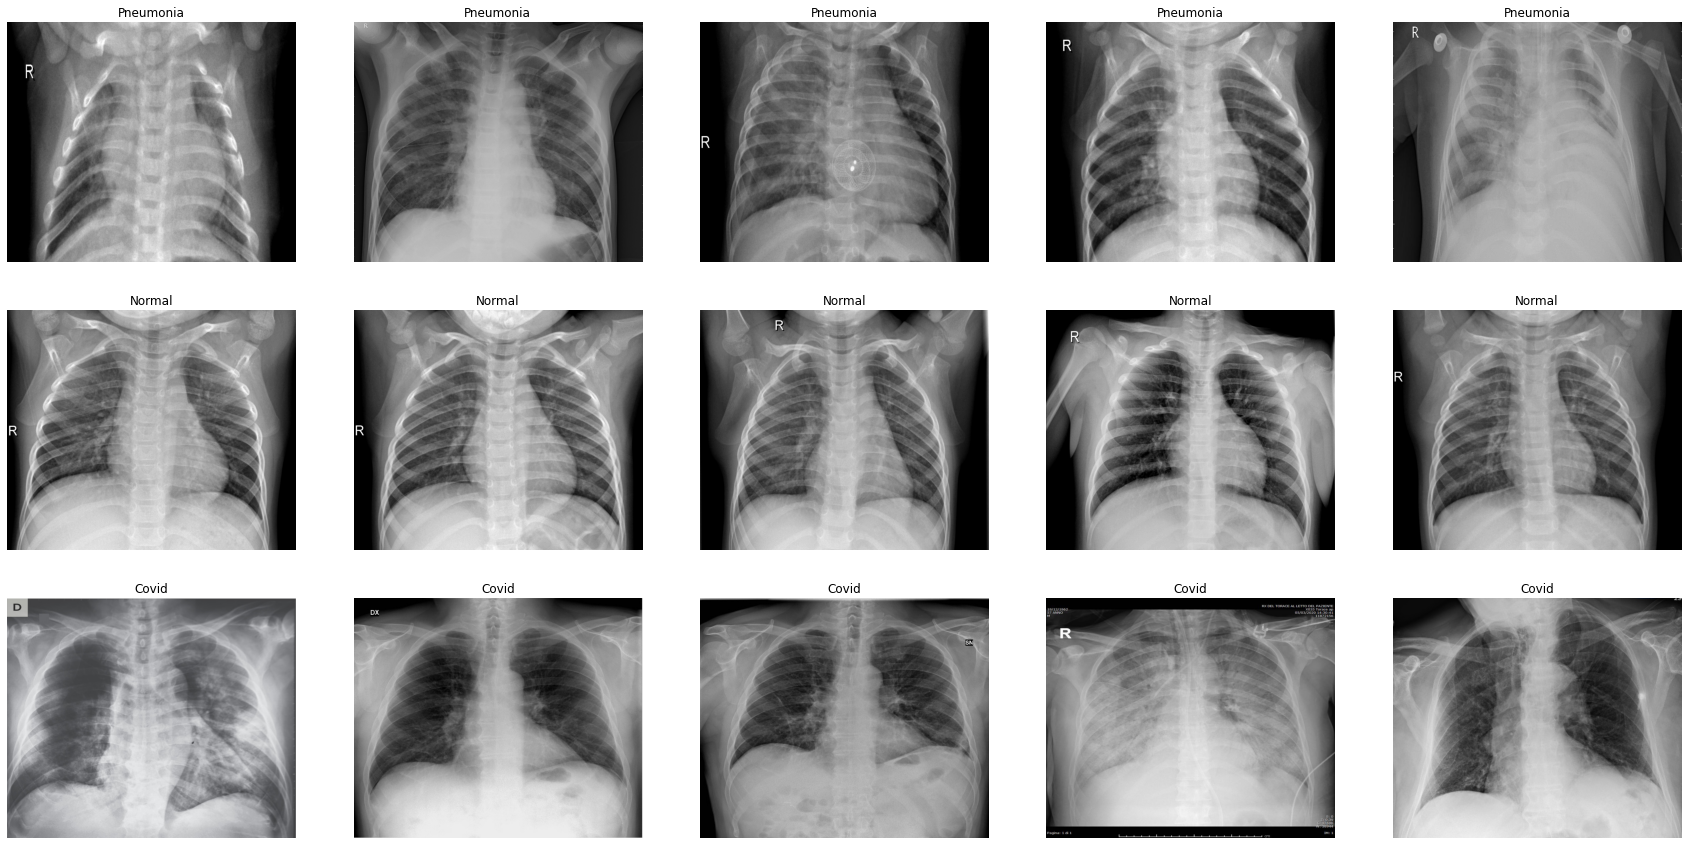

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

##Nosso botton model

In [0]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

#assim ficou horrivel
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(1024, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)
  # top_model = Dense(512, activation='relu')(top_model)

##DenseNet201

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
  5/116 [>.............................] - ETA: 42:58 - loss: 0.6573 - accuracy: 0.6667

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


  9/116 [=>............................] - ETA: 42:15 - loss: 0.5965 - accuracy: 0.6921

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 66 could not be retrieved. It could be because a worker has died.
  UserWarning)


 20/116 [====>.........................] - ETA: 38:35 - loss: 0.5885 - accuracy: 0.7167

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


 24/116 [=====>........................] - ETA: 37:31 - loss: 0.5728 - accuracy: 0.7305

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 89 could not be retrieved. It could be because a worker has died.
  UserWarning)


 25/116 [=====>........................] - ETA: 38:37 - loss: 0.5675 - accuracy: 0.7313

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


 30/116 [======>.......................] - ETA: 35:32 - loss: 0.5326 - accuracy: 0.7523

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 73 could not be retrieved. It could be because a worker has died.
  UserWarning)


 46/116 [==========>...................] - ETA: 26:46 - loss: 0.4677 - accuracy: 0.7875

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


 48/116 [===========>..................] - ETA: 26:30 - loss: 0.4625 - accuracy: 0.7907

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


 56/116 [=============>................] - ETA: 23:09 - loss: 0.4455 - accuracy: 0.7992

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


 62/116 [===============>..............] - ETA: 20:41 - loss: 0.4284 - accuracy: 0.8056

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 112 could not be retrieved. It could be because a worker has died.
  UserWarning)


104/116 [=========================>....] - ETA: 4:22 - loss: 0.3717 - accuracy: 0.8328

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 106 could not be retrieved. It could be because a worker has died.
  UserWarning)


107/116 [==========================>...] - ETA: 3:17 - loss: 0.3668 - accuracy: 0.8358

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


108/116 [==========================>...] - ETA: 2:58 - loss: 0.3668 - accuracy: 0.8362

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


109/116 [===========================>..] - ETA: 2:36 - loss: 0.3659 - accuracy: 0.8363

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)


115/116 [============================>.] - ETA: 22s - loss: 0.3638 - accuracy: 0.8376

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


116/116 [==============================] - 3072s 26s/step - loss: 0.3630 - accuracy: 0.8378 - val_loss: 0.9791 - val_accuracy: 0.6703

Epoch 00001: val_loss improved from inf to 0.97907, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet201-v7-.h5
Epoch 2/100
116/116 [==============================] - 69s 592ms/step - loss: 0.2863 - accuracy: 0.8837 - val_loss: 0.6992 - val_accuracy: 0.7253

Epoch 00002: val_loss improved from 0.97907 to 0.69917, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet201-v7-.h5
Epoch 3/100
116/116 [==============================] - 68s 587ms/step - loss: 0.2345 - accuracy: 0.9043 - val_loss: 0.9046 - val_accuracy: 0.6860

Epoch 00003: val_loss did not improve from 0.69917
Epoch 4/100
116/116 [==============================] - 68s 583ms/step - loss: 0.2103 - accuracy: 0.9164 - val_loss: 0.4988 - val_accuracy: 0.7817

Epoch 00004: val_loss improved from 0.69917 to 0.49884, saving model to /content/drive/My Drive

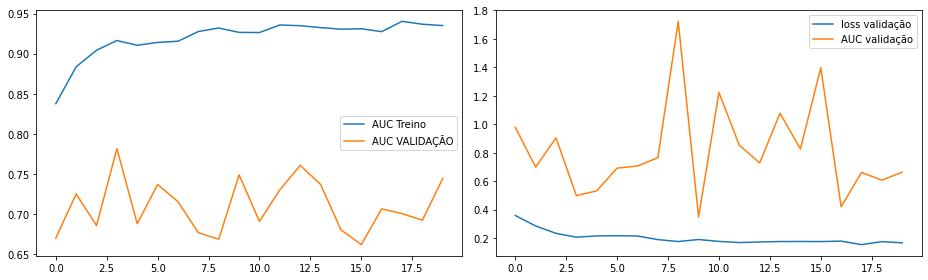

In [0]:
#DenseNet201
DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet201'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet121

##teste 1 - 1 dense de 1024

29089792/29084464 [==============================] - 7s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


116/116 [==============================] - 1740s 15s/step - loss: 0.4240 - accuracy: 0.8162 - val_loss: 0.4019 - val_accuracy: 0.8103

Epoch 00001: val_loss improved from inf to 0.40188, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet121-v7-.h5
Epoch 2/100
116/116 [==============================] - 84s 726ms/step - loss: 0.3378 - accuracy: 0.8524 - val_loss: 0.3233 - val_accuracy: 0.8597

Epoch 00002: val_loss improved from 0.40188 to 0.32331, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet121-v7-.h5
Epoch 3/100
116/116 [==============================] - 84s 721ms/step - loss: 0.2503 - accuracy: 0.8955 - val_loss: 0.2254 - val_accuracy: 0.8886

Epoch 00003: val_loss improved from 0.32331 to 0.22538, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/DenseNet121-v7-.h5
Epoch 4/100
116/116 [==============================] - 83s 717ms/step - loss: 0.2470 - accuracy: 0.9000 - val_loss: 0.3946 - val_accuracy: 0.7936

Epoch

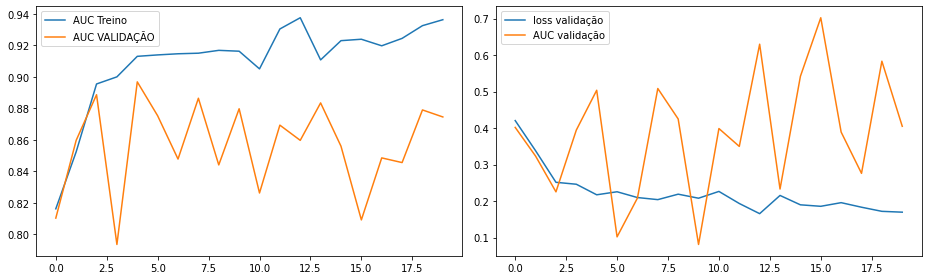

In [7]:
#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##teste 2 - Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

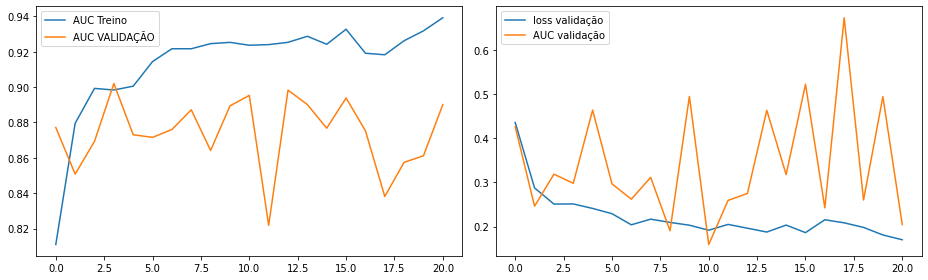

In [13]:
#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##teste 3 - 6 dense decrescentes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

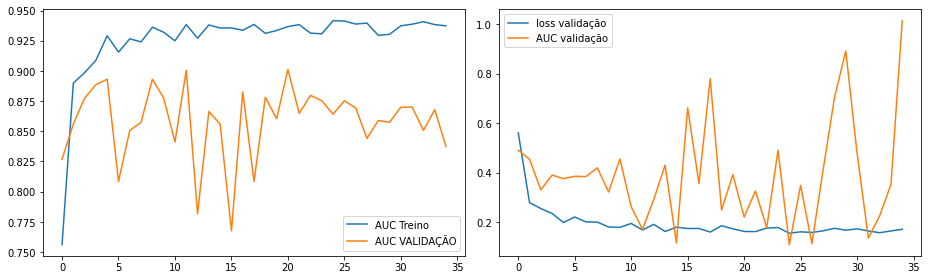

In [18]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 4 - 2 dense 1024, 512 COM SGD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

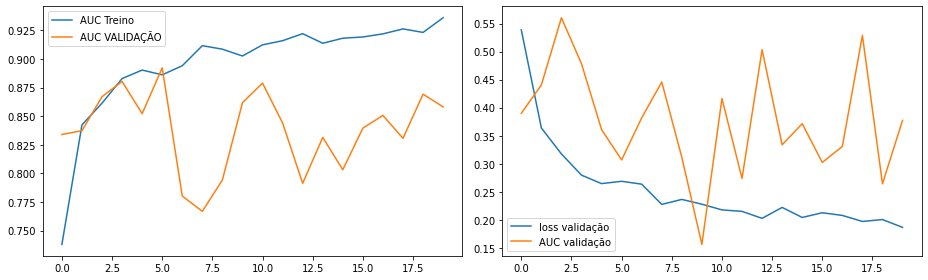

In [19]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 5 - 6 dense decrescente - Com SGD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

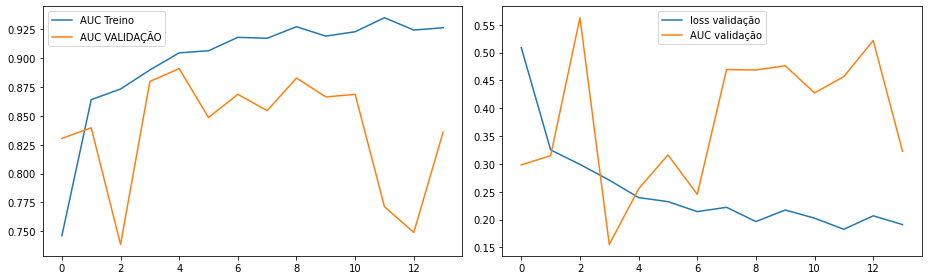

In [20]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(1024, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(512, activation='relu', kernel_initializer='he_normal')(top_model)

  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Teste 6 - 1 dense 256

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 1859 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_________

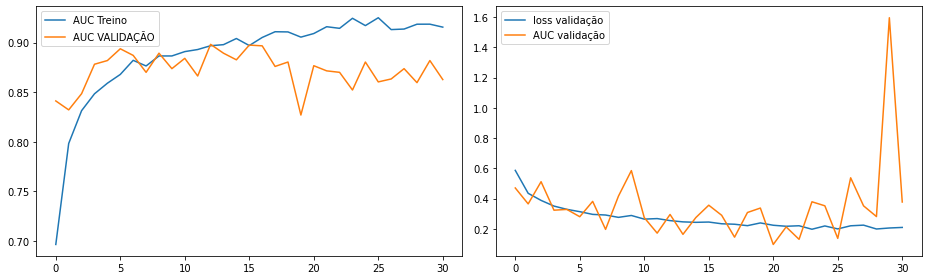

In [21]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#from sklearn.metrics import classification_report, confuzion_matrix

%matplotlib inline

#DenseNet201
DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet121.layers:
  layer.trainable=False

def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(256, activation='relu', kernel_initializer='he_normal')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation='sigmoid')(top_model)

  return top_model

FC = addTopModel(DenseNet121, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet121.input, output=FC) #bottom layers, top layer

#data augmentation
train_datagen = ImageDataGenerator(samplewise_center=False,
                                   samplewise_std_normalization=False,
                                   brightness_range=[0.7, 1.5],
                                   rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.125,
                                   shear_range=0.01,
                                   fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(samplewise_center=False,
                                        samplewise_std_normalization=False,
                                        brightness_range=[0.7, 1.5],
                                        rescale=1./255,
                                        rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        zoom_range=0.125,
                                        shear_range=0.01,
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


model.summary()

checkpoint = ModelCheckpoint(data_dir+'DenseNet121'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##ResNet50v2

234553344/234545216 [==============================] - 8s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 204s 2s/step - loss: 0.7091 - accuracy: 0.7754 - val_loss: 0.2523 - val_accuracy: 0.7845

Epoch 00001: val_loss improved from inf to 0.25228, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/ResNet152V2-v6-.h5
Epoch 2/100
116/116 [==============================] - 200s 2s/step - loss: 0.3415 - accuracy: 0.8730 - val_loss: 1.1077 - val_accuracy: 0.5145

Epoch 00002: val_loss did not improve from 0.25228
Epoch 3/100
116/116 [==============================] - 195s 2s/step - loss: 0.3012 - accuracy: 0.8828 - val_loss: 0.7331 - val_accuracy: 0.5857

Epoch 00003: val_loss did not improve from 0.25228
Epoch 4/100
116/116 [==============================] - 198s 2s/step - loss: 0.3101 - accuracy: 0.8882 - val_loss: 1.2433 - val_accuracy: 0.5256

Epoch 00004: val_loss did not improve from 0.25228
Epoch 5/100
116/116 [==============================] - 195s 2s/step - loss: 0.2603 - accuracy: 0.9034 - val_loss: 0.7728 - val_acc

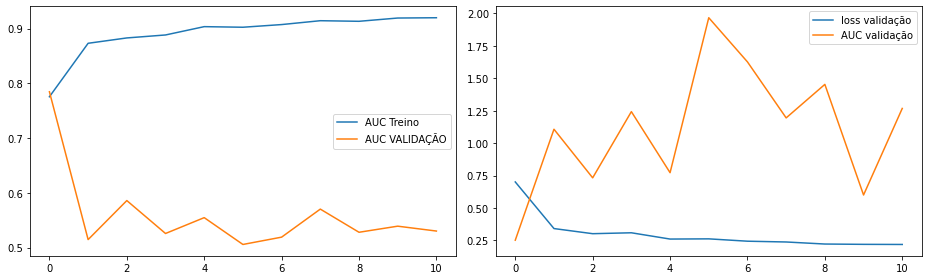

In [0]:
#ResNet152V2
ResNet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido, 1pb

for layer in ResNet152V2.layers:
  layer.trainable=False

FC = addTopModel(ResNet152V2, num_classes) #MobileNet = bottom_model
model = Model(input=ResNet152V2.input, output=FC) #bottom layers, top layer

#model.summary()

name_model = 'ResNet152V2'+version+'.h5'

checkpoint = ModelCheckpoint(data_dir+'ResNet152V2'+version+'.h5',
                            monitor='val_loss',
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

#confuzin and matrix
#print(classification_report())

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##InceptionResNetv2

219062272/219055592 [==============================] - 7s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 208s 2s/step - loss: 0.8953 - accuracy: 0.6354 - val_loss: 0.6794 - val_accuracy: 0.5237

Epoch 00001: val_loss improved from inf to 0.67940, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/InceptionResNetV2-v6-.h5
Epoch 2/100
116/116 [==============================] - 198s 2s/step - loss: 0.5293 - accuracy: 0.7906 - val_loss: 1.5585 - val_accuracy: 0.5033

Epoch 00002: val_loss did not improve from 0.67940
Epoch 3/100
116/116 [==============================] - 194s 2s/step - loss: 0.4829 - accuracy: 0.8171 - val_loss: 0.7430 - val_accuracy: 0.5056

Epoch 00003: val_loss did not improve from 0.67940
Epoch 4/100
116/116 [==============================] - 195s 2s/step - loss: 0.4531 - accuracy: 0.8133 - val_loss: 3.0422 - val_accuracy: 0.4855

Epoch 00004: val_loss did not improve from 0.67940
Epoch 5/100
116/116 [==============================] - 194s 2s/step - loss: 0.4133 - accuracy: 0.8399 - val_loss: 1.4874 - v

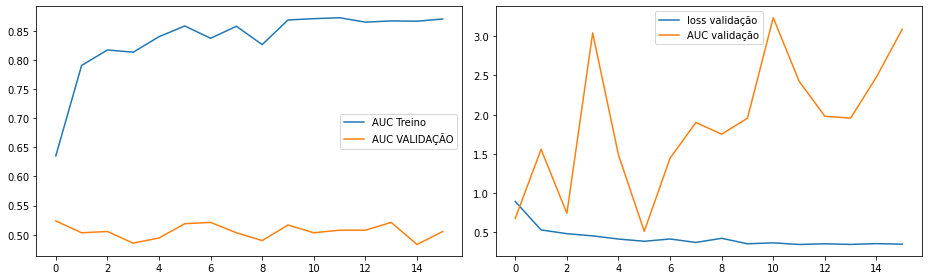

In [0]:
#InceptionResNetV2
InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionResNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Inceptionv3

In [0]:
#Inception2
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'InceptionV3'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

87916544/87910968 [==============================] - 6s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


NameError: ignored

##VGG19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 66s 571ms/step - loss: 0.4769 - accuracy: 0.7705 - val_loss: 0.1823 - val_accuracy: 0.8614

Epoch 00001: val_loss improved from inf to 0.18227, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/VGG19-v7-.h5
Epoch 2/100
116/116 [==============================] - 69s 591ms/step - loss: 0.3853 - accuracy: 0.8314 - val_loss: 0.2381 - val_accuracy: 0.8493

Epoch 00002: val_loss did not improve from 0.18227
Epoch 3/100
116/116 [==============================] - 68s 584ms/step - loss: 0.3452 - accuracy: 0.8530 - val_loss: 0.3734 - val_accuracy: 0.8753

Epoch 00003: val_loss did not improve from 0.18227
Epoch 4/100
116/116 [==============================] - 67s 582ms/step - loss: 0.3403 - accuracy: 0.8593 - val_loss: 0.2998 - val_accuracy: 0.8827

Epoch 00004: val_loss did not improve from 0.18227
Epoch 5/100
116/116 [==============================] - 66s 573ms/step - loss: 0.3220 - accuracy: 0.8634 - val_loss: 0.3711 - val

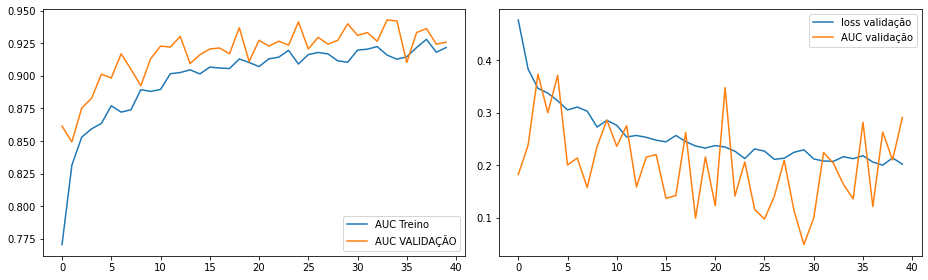

In [0]:
#VGG19
VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in VGG19.layers:
  layer.trainable=False

FC = addTopModel(VGG19, num_classes) #MobileNet = bottom_model
model = Model(input=VGG19.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'VGG19'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##MobileNet

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 179s 2s/step - loss: 0.6088 - accuracy: 0.7705 - val_loss: 2.7006 - val_accuracy: 0.5108

Epoch 00001: val_loss improved from inf to 2.70064, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/MobileNetV2-v6-.h5
Epoch 2/100
116/116 [==============================] - 185s 2s/step - loss: 0.4016 - accuracy: 0.8421 - val_loss: 0.9877 - val_accuracy: 0.5011

Epoch 00002: val_loss improved from 2.70064 to 0.98772, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/MobileNetV2-v6-.h5
Epoch 3/100
116/116 [==============================] - 182s 2s/step - loss: 0.3525 - accuracy: 0.8633 - val_loss: 1.9153 - val_accuracy: 0.5033

Epoch 00003: val_loss did not improve from 0.98772
Epoch 4/100
116/116 [==============================] - 181s 2s/step - loss: 0.3057 - accuracy: 0.8909 - val_loss: 1.4788 - val_accuracy: 0.5033

Epoch 00004: val_loss did not improve from 0.98772
Epoch 5/100
116/116 [===================

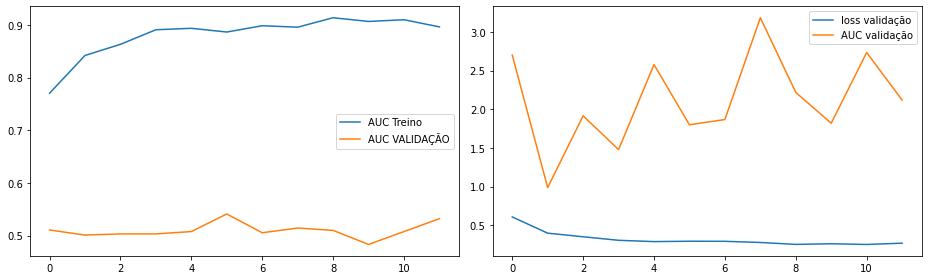

In [0]:
#MobileNetV2
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNetV2.layers:
  layer.trainable=False

FC = addTopModel(MobileNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'MobileNetV2'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##CheXNet

In [0]:
#NASNetLarge
NASNetLarge = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in NASNetLarge.layers:
  layer.trainable=False

FC = addTopModel(NASNetLarge, num_classes) #MobileNet = bottom_model
model = Model(input=NASNetLarge.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('NASNetLarge'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Xcepiton

In [0]:
#Xception
Xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in Xception.layers:
  layer.trainable=False

FC = addTopModel(Xception, num_classes) #MobileNet = bottom_model
model = Model(input=Xception.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint(data_dir+'Xception'+version+'.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_train_total//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=len_val_total//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

# print()
# # Evaluate the model
# scores = history.history.evaluate_generator(test_generator)
# print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

83689472/83683744 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Epoch 1/100
116/116 [==============================] - 67s 580ms/step - loss: 0.9535 - accuracy: 0.5247 - val_loss: 0.8555 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 0.85552, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 2/100
116/116 [==============================] - 65s 557ms/step - loss: 0.8526 - accuracy: 0.6245 - val_loss: 0.6441 - val_accuracy: 0.5367

Epoch 00002: val_loss improved from 0.85552 to 0.64410, saving model to /content/drive/My Drive/UNICAMP/databases/covid19/Xception-v6-.h5
Epoch 3/100
116/116 [==============================] - 62s 537ms/step - loss: 0.8074 - accuracy: 0.6679 - val_loss: 0.8354 - val_accuracy: 0.5657

Epoch 00003: val_loss did not improve from 0.64410
Epoch 4/100
116/116 [==============================] - 62s 532ms/step - loss: 0.7918 - accuracy: 0.6886 - val_loss: 0.6802 - val_accuracy: 0.5301

Epoch 00004: val_loss did not improve from 0.64410
Epoch 5/100
116/116 [=================

KeyboardInterrupt: ignored

#Resultados

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))